# < CycleGAN - Summer To Winter >

이 프로젝트는 CycleGAN을 통하여 여름 풍경 사진을 겨울 풍경 사진으로 변환하는 프로젝트입니다.

In [0]:
!pip install --upgrade tensorflow

In [0]:
!pip install h5py pyyaml

## (1) 데이터셋 다운로드

In [4]:
import tensorflow as tf
print(tf.__version__)

2.1.0


In [5]:
from __future__ import absolute_import, division, print_function, unicode_literals



import os
import time
import matplotlib.pyplot as plt
import numpy as np
from numpy import random
from IPython.display import clear_output


from PIL import Image
import cv2


AUTOTUNE = tf.data.experimental.AUTOTUNE

Tensorfow Dataset에서 summer2winter_yosemite 데이터 셋을 가져온 후, 분리한다.

In [6]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

## (2) 데이터셋 학습 전 준비 과정

In [7]:
#이미지 주어진 크기에 따라 랜덤으로 분할,
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

In [8]:
# "-1 <= image <= 1" 로 변환
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

In [9]:
#이미지 변환 처리 중..
def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

In [10]:
def preprocess_image_train(image, label):
  image = random_jitter(image)
  image = normalize(image)
  return image

In [11]:
def preprocess_image_test(image, label):
  image = normalize(image)
  return image

In [12]:
def preprocess_image_train_nl(image):
  image = random_jitter(image)
  image = normalize(image)
  return image

In [13]:
class imagedata:
  def __init__(self, path,  w = 128, h = 192):
    self.outp = Image.open(path).convert("RGB")
    
    self.outp = self.outp.resize((w, h))
    area = (0, 0, int(w/4), int(h/4))
    self.inp = self.outp.crop(area)
    self.inp = self.inp.resize((w, h))
    self.oinp = self.inp
    self.ooutp = self.outp
    self.inp = np.array(self.oinp)
    self.outp = np.array(self.ooutp)
    self.inp = cv2.cvtColor(self.inp, cv2.COLOR_BGR2RGB)
    self.outp = cv2.cvtColor(self.outp, cv2.COLOR_BGR2RGB)
    self.inp = preprocess_image_train_nl(self.inp)
    self.outp = preprocess_image_train_nl(self.outp)

In [14]:
PATH_DIR='./Dataset/'
filelist = []

for i in [file for file in os.listdir(PATH_DIR) if file.endswith(".png") or file.endswith(".jpg") or file.endswith(".jpge")]:
  filelist.append(imagedata(PATH_DIR + str(i)))

C:\Users\82105\anaconda3\lib\site-packages\PIL\Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


## (3) 각 데이터셋의 첫 데이터를 띄운다.

## (4) CycleGAN 신경망 구성
> https://subinium.github.io/introduction-to-normalization/ : 정규화에 대한 글

In [15]:
#인스턴스 정규화 (IN) - 각 채널에서 정규화가 이루어짐
class InstanceNormalization(tf.keras.layers.Layer):
  def __init__(self, epsilon=1e-5):
    super(InstanceNormalization, self).__init__()
    self.epsilon = epsilon

  def build(self, input_shape):
    self.scale = self.add_weight(
        name='scale',
        shape=input_shape[-1:],
        initializer=tf.random_normal_initializer(1., 0.02),
        trainable=True)

    self.offset = self.add_weight(
        name='offset',
        shape=input_shape[-1:],
        initializer='zeros',
        trainable=True)

  def call(self, x):
    mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
    inv = tf.math.rsqrt(variance + self.epsilon)
    normalized = (x - mean) * inv
    return self.scale * normalized + self.offset

In [16]:
#다운샘플링 - UNET의 하강 부분에서 학습데이터를 압축하여 feature을 얻어내는 역할을 함.
def downsample(filters, size, norm_type='batchnorm', apply_norm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_norm:
    if norm_type.lower() == 'batchnorm':
      result.add(tf.keras.layers.BatchNormalization())
    elif norm_type.lower() == 'instancenorm':
      result.add(InstanceNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

#업샘플링 - UNET의 상승 부분에서 학습데이터를 압축 해제하여, 원래 학습 데이터와 해상도를 일치시키는 역할을 함.
def upsample(filters, size, norm_type='batchnorm', apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

  if norm_type.lower() == 'batchnorm':
    result.add(tf.keras.layers.BatchNormalization())
  elif norm_type.lower() == 'instancenorm':
    result.add(InstanceNormalization())

  if apply_dropout:
    result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [17]:
#CycleGAN의 Generator 신경망을 U-NET으로 구성하는 역할을 함
def unet_generator(output_channels, norm_type='batchnorm'):
  down_stack = [
      downsample(64, 4, norm_type, apply_norm=False),  # (bs, 128, 128, 64)
      downsample(128, 4, norm_type),  # (bs, 64, 64, 128)
      downsample(256, 4, norm_type),  # (bs, 32, 32, 256)
      downsample(512, 4, norm_type),  # (bs, 16, 16, 512)
      downsample(512, 4, norm_type),  # (bs, 8, 8, 512)
      downsample(512, 4, norm_type),  # (bs, 4, 4, 512)
      downsample(512, 4, norm_type),  # (bs, 2, 2, 512)
      downsample(512, 4, norm_type),  # (bs, 1, 1, 512)
  ]

  up_stack = [
      upsample(512, 4, norm_type, apply_dropout=True),  # (bs, 2, 2, 1024)
      upsample(512, 4, norm_type, apply_dropout=True),  # (bs, 4, 4, 1024)
      upsample(512, 4, norm_type, apply_dropout=True),  # (bs, 8, 8, 1024)
      upsample(512, 4, norm_type),  # (bs, 16, 16, 1024)
      upsample(256, 4, norm_type),  # (bs, 32, 32, 512)
      upsample(128, 4, norm_type),  # (bs, 64, 64, 256)
      upsample(64, 4, norm_type),  # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 4, strides=2,
      padding='same', kernel_initializer=initializer,
      activation='tanh')  # (bs, 256, 256, 3)

  concat = tf.keras.layers.Concatenate()

  inputs = tf.keras.layers.Input(shape=[None, None, 3])
  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = concat([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

#CycleGAN의 Discriminato 신경망을 구성하는 역할을 함
def discriminator(norm_type='batchnorm', target=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[None, None, 3], name='input_image')
  x = inp

  if target:
    tar = tf.keras.layers.Input(shape=[None, None, 3], name='target_image')
    x = tf.keras.layers.concatenate([inp, tar])  # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, norm_type, False)(x)  # (bs, 128, 128, 64)
  down2 = downsample(128, 4, norm_type)(down1)  # (bs, 64, 64, 128)
  down3 = downsample(256, 4, norm_type)(down2)  # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(
      512, 4, strides=1, kernel_initializer=initializer,
      use_bias=False)(zero_pad1)  # (bs, 31, 31, 512)

  if norm_type.lower() == 'batchnorm':
    norm1 = tf.keras.layers.BatchNormalization()(conv)
  elif norm_type.lower() == 'instancenorm':
    norm1 = InstanceNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(norm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(
      1, 4, strides=1,
      kernel_initializer=initializer)(zero_pad2)  # (bs, 30, 30, 1)

  if target:
    return tf.keras.Model(inputs=[inp, tar], outputs=last)
  else:
    return tf.keras.Model(inputs=inp, outputs=last)

## (5) 신경망 준비
*Generator* 함수 **G**와 **F**는 ***역함수*** 관계</br>
*Discriminator* 함수 **X**와 **Y**는 ***역함수*** 관계

In [18]:
OUTPUT_CHANNELS = 3

generator_g = unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = discriminator(norm_type='instancenorm', target=False)
discriminator_y = discriminator(norm_type='instancenorm', target=False)

In [19]:
LAMBDA = 10

In [20]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [21]:
#Discriminator 함수의 손실 구하기
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [22]:
#Generator 함수의 손실 구하기
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

In [23]:
#Generator을 통하여 변환된 이미지와 실제 이미지 사이의 손실 계산
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  
  return LAMBDA * loss1

In [24]:
#CycleGAN과 GAN의 차이인 "생성된 이미지 -> 원래 이미지"의 복원 가능성 손실 계산
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

In [25]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = random.permutation(a.shape[0])
    return a[p], b[p]

## (9) 학습 준비

In [26]:
#옵티마이저 설정
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [27]:
#만약 전에 학습시킨 모델이 있다면, 불러와서 이어서 학습 & 없다면 새로 학습
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [28]:
#학습 횟수
EPOCHS = 30000

In [29]:
#이미지를 Generator을 통해서 "여름->겨울"로 변환하는 함수
def generate_images(model, test_input):
  prediction = model(test_input[np.newaxis])
  test_input1 = cv2.resize(test_input[np.newaxis][0], dsize=(128, 192), interpolation=cv2.INTER_AREA)
  prediction1 = cv2.resize(np.array(prediction[0]), dsize=(128, 192), interpolation=cv2.INTER_AREA)
  plt.figure(figsize=(12, 12))


  display_list = [test_input1, prediction1]
  title = ['Input Image', 'Predicted Image']
  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  
  plt.show()

In [30]:
#이미지를 Generator을 통해서 "여름->겨울"로 변환하는 함수
def generate_images_r(model, test_input, real_output):
  prediction = model(test_input[np.newaxis])
  test_input1 = cv2.resize(test_input[np.newaxis][0], dsize=(128, 192), interpolation=cv2.INTER_AREA)
  prediction1 = cv2.resize(np.array(prediction[0]), dsize=(128, 192), interpolation=cv2.INTER_AREA)
  plt.figure(figsize=(12, 12))


  real_output1 = cv2.resize(real_output[np.newaxis][0], dsize=(128, 192), interpolation=cv2.INTER_AREA)
  display_list = [test_input1, prediction1, real_output1]
  title = ['Input Image', 'Predicted Image', 'Real Image']
  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')

  
  plt.show()

In [31]:
def sampling(train_x, train_y, batch_size) :
  train_xb = np.empty(shape=[0, IMG_HEIGHT, IMG_WIDTH, 3], dtype='float32')
  train_yb = np.empty(shape=[0, IMG_HEIGHT, IMG_WIDTH, 3], dtype='float32')
  listaa = np.arange(train_x.shape[0])
  listaa = np.random.choice(listaa, batch_size, replace=False)
  for i in listaa:
    train_xb = np.append(train_xb, train_x[i][np.newaxis], axis=0)
    train_yb = np.append(train_yb, train_y[i][np.newaxis], axis=0)
  return train_xb, train_yb

## (10) 학습 함수 구성

In [39]:
#학습 함수
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G 는 X -> Y 로 변환
    # Generator F 는 Y -> X 로 변환


    fake_y = generator_g(real_x, training=True)

    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)

    cycled_y = generator_g(fake_x, training=True)

    # same_x & same_y 는 "생성된 이미지 -> 원래 이미지"의 복원 가능성 손실 계산에 이용됨.
    same_x = generator_f(real_x, training=True)

    same_y = generator_g(real_y, training=True)


    
    disc_real_x = discriminator_x(real_x, training=True)

    disc_real_y = discriminator_y(real_y, training=True)


    disc_fake_x = discriminator_x(fake_x, training=True)

    disc_fake_y = discriminator_y(fake_y, training=True)


    # 해당 손실 연산
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)
    
    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
    
    # 총합 손실 연산 (Generator_g의 역함수 Generator_f에 대한 손실 계산 삭제)
    total_gen_g_loss = gen_g_loss + total_cycle_loss# + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss# + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
  
  # 가중치 연산

  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)

  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)

  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)

  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)
  
  # 가중치 갱신

  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))

  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))


In [33]:
'''train_x = []
train_y = []

for i in filelist:
  print("인풋 배열 크기 : " + str(i.inp.shape))
  print("아웃풋 배열 크기" + str(i.outp.shape))
  train_x.append(i.inp)
  train_y.append(i.outp)'''

'train_x = []\ntrain_y = []\n\nfor i in filelist:\n  print("인풋 배열 크기 : " + str(i.inp.shape))\n  print("아웃풋 배열 크기" + str(i.outp.shape))\n  train_x.append(i.inp)\n  train_y.append(i.outp)'

In [34]:
train_x = np.empty(shape=[0, IMG_HEIGHT, IMG_WIDTH, 3], dtype='float32')
train_y = np.empty(shape=[0, IMG_HEIGHT, IMG_WIDTH, 3], dtype='float32')

numi = 1
for i in filelist:
  #print("인풋 배열 크기 : " + str(i.inp.shape))
  #print("아웃풋 배열 크기" + str(i.outp.shape))
  #train_x.append(i.inp)
  print(str(numi) + "번째 이미지 로드 중..")
  numi = numi + 1
  train_x = np.append(train_x, i.inp[np.newaxis], axis=0)
  train_y = np.append(train_y, i.outp[np.newaxis], axis=0)
  #train_y.append(i.outp)

1번째 이미지 로드 중..
2번째 이미지 로드 중..
3번째 이미지 로드 중..
4번째 이미지 로드 중..
5번째 이미지 로드 중..
6번째 이미지 로드 중..
7번째 이미지 로드 중..
8번째 이미지 로드 중..
9번째 이미지 로드 중..
10번째 이미지 로드 중..
11번째 이미지 로드 중..
12번째 이미지 로드 중..
13번째 이미지 로드 중..
14번째 이미지 로드 중..
15번째 이미지 로드 중..
16번째 이미지 로드 중..
17번째 이미지 로드 중..
18번째 이미지 로드 중..
19번째 이미지 로드 중..
20번째 이미지 로드 중..
21번째 이미지 로드 중..
22번째 이미지 로드 중..
23번째 이미지 로드 중..
24번째 이미지 로드 중..
25번째 이미지 로드 중..
26번째 이미지 로드 중..
27번째 이미지 로드 중..
28번째 이미지 로드 중..
29번째 이미지 로드 중..
30번째 이미지 로드 중..
31번째 이미지 로드 중..
32번째 이미지 로드 중..
33번째 이미지 로드 중..
34번째 이미지 로드 중..
35번째 이미지 로드 중..
36번째 이미지 로드 중..
37번째 이미지 로드 중..
38번째 이미지 로드 중..
39번째 이미지 로드 중..
40번째 이미지 로드 중..
41번째 이미지 로드 중..
42번째 이미지 로드 중..
43번째 이미지 로드 중..
44번째 이미지 로드 중..
45번째 이미지 로드 중..
46번째 이미지 로드 중..
47번째 이미지 로드 중..
48번째 이미지 로드 중..
49번째 이미지 로드 중..
50번째 이미지 로드 중..
51번째 이미지 로드 중..
52번째 이미지 로드 중..
53번째 이미지 로드 중..
54번째 이미지 로드 중..
55번째 이미지 로드 중..
56번째 이미지 로드 중..
57번째 이미지 로드 중..
58번째 이미지 로드 중..
59번째 이미지 로드 중..
60번째 이미지 로드 중..
61번째 이미지 로드 중..
62번째 이미지 로드 중..
63번째 이미지 로드 중..
6

In [35]:
print("train_x의 크기 : " + str(train_x.shape))
print("train_y의 크기 : " + str(train_y.shape))

train_x의 크기 : (1648, 256, 256, 3)
train_y의 크기 : (1648, 256, 256, 3)


In [36]:
train_x[2:2+1, :, :, :].shape

(1, 256, 256, 3)

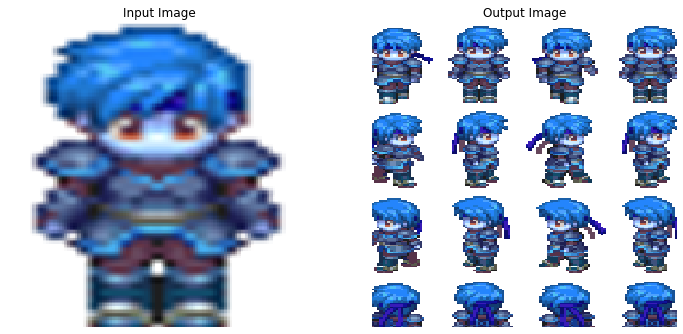

In [37]:
plt.figure(figsize=(12, 12))
display_list = [train_x[0], train_y[0]]
title = ['Input Image', 'Output Image']
for i in range(2):
  plt.subplot(1, 2, i+1)
  plt.title(title[i])
  plt.imshow(display_list[i] * 0.5 + 0.5)
  plt.axis('off')

plt.show()

## (11) 학습 시작

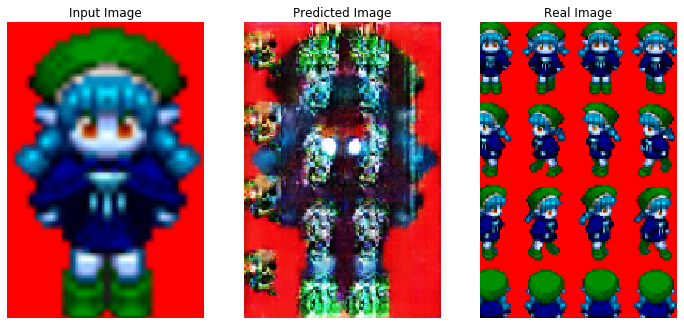

7791번째 학습 시작


In [ ]:
cepoch=7786
for epoch in range(EPOCHS):


  a, b = sampling(train_x, train_y, 15)
  print("{0}번째 학습 시작".format(epoch+cepoch+1))
  train_step(a, b)
  print("{0}번째 학습 완료".format(epoch+cepoch+1))
  '''
  n = 0
  for image_x, image_y in tf.data.Dataset.zip((train_x, train_y)):
    print("for문 진입")
    train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    n+=1'''

  



  clear_output(wait=True)
  # Using a consistent image (sample_summer) so that the progress of the model
  # is clearly visible.
  generate_images_r(generator_g, a[0], b[0])

  if (epoch + 1) % 5 == 0:
    try :
      ckpt_save_path = ckpt_manager.save()
    except :
      pass
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+cepoch+1,
                                                         ckpt_save_path))

## (12) 테스트 데이터에서 몇개를 추출하여 변환 테스트

In [ ]:
generate_images_r(generator_g, train_x[0], train_y[0])

In [45]:
generator_g.save('my_model.h5')

NotImplementedError: Layers with arguments in `__init__` must override `get_config`.

In [40]:
generator_g.save('saved_model/generator_g', save_format='tf')
print("generator_g 저장 완료")
generator_f.save('saved_model/generator_f', save_format='tf')
print("generator_f 저장 완료")
discriminator_x.save('saved_model/discriminator_x', save_format='tf')
print("discriminator_x 저장 완료")
discriminator_y.save('saved_model/discriminator_y', save_format='tf')
print("discriminator_y 저장 완료")

INFO:tensorflow:Assets written to: saved_model/generator_g\assets
generator_g 저장 완료
INFO:tensorflow:Assets written to: saved_model/generator_f\assets
generator_f 저장 완료
INFO:tensorflow:Assets written to: saved_model/discriminator_x\assets
discriminator_x 저장 완료


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xb4 in position 306: invalid start byte

In [ ]:
def get_config(self):

        config = super().get_config().copy()
        config.update({
            'vocab_size': self.vocab_size,
            'num_layers': self.num_layers,
            'units': self.units,
            'd_model': self.d_model,
            'num_heads': self.num_heads,
            'dropout': self.dropout,
        })
        return config

In [ ]:
modelaa = tf.keras.models.Sequential()
modelaa = tf.keras.models.load_model('./saved_model/generator_g.h5')
generate_images_r(modelaa, train_x[0], train_y[0])

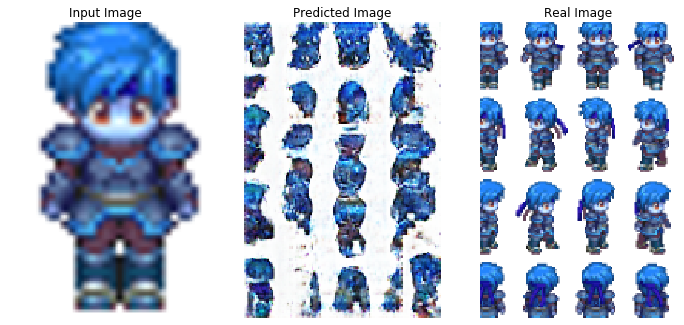

In [43]:
model = tf.keras.models.load_model('saved_model/generator_g')
generate_images_r(model, train_x[0], train_y[0])